<a href="https://colab.research.google.com/github/HendieLo/DeepLearning-on-Medicinal-plants/blob/main/Mizimu_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import itertools
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Download and extract links.skrypt.it/mizimu.zip

# Step 1: Import necessary libraries
import zipfile
import requests

url = "http://links.skrypt.it/mizimu.zip"

response = requests.get(url)

with open("mizimu.zip", "wb") as file:
    file.write(response.content)

with zipfile.ZipFile("mizimu.zip", "r") as zip_ref:
    zip_ref.extractall("mizimu")


TF version: 2.18.0
Hub version: 0.16.1
GPU is available


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
data_dir="mizimu"

In [ ]:
def build_dataset(subset, batch_size=1, label_mode="int"):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode=label_mode,
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=batch_size)

In [ ]:
train_ds = build_dataset("training", batch_size=BATCH_SIZE)
val_ds = build_dataset("validation", batch_size=BATCH_SIZE)
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 4)
val_ds = val_ds.skip(val_batches // 4)
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)


NameError: name 'build_dataset' is not defined

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = keras.Sequential(
  [
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0, 0.2),
    layers.RandomTranslation(0.2, 0),
    layers.RandomZoom(0.2, 0.2),
    layers.RandomFlip(mode="horizontal"),
  ]
)

model = Sequential([
  layers.InputLayer(input_shape=INPUT_SHAPE),
  preprocessing_model,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint

def get_class_weights(dataset):
    counts = {}
    for images, labels in dataset.unbatch():
        label = int(labels.numpy())
        counts[label] = counts.get(label, 0) + 1
    total_count = sum(counts.values())
    class_weights = {i: total_count / (num_classes * count) for i, count in counts.items()}
    return class_weights

class_weights = get_class_weights(train_ds)

checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weights,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.1225 - loss: 2.4870 - val_accuracy: 0.3026 - val_loss: 1.7649
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3326 - loss: 1.6520 - val_accuracy: 0.5132 - val_loss: 1.4516
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4964 - loss: 1.3750 - val_accuracy: 0.5789 - val_loss: 1.2196
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5972 - loss: 1.1420 - val_accuracy: 0.6711 - val_loss: 1.0279
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6087 - loss: 1.0429 - val_accuracy: 0.7105 - val_loss: 0.8872
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7129 - loss: 0.7784 - val_accuracy: 0.7237 - val_loss: 0.9648
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6963 - loss: 0.7911 - val_accuracy: 0.8289 - val_loss: 0.6830
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7500 - loss: 0.6562 - val_accuracy: 0.7895 - val_loss: 0

In [ ]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
loss, accuracy = best_model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9688 - loss: 0.1146


In [ ]:
def plot_learning_curve(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
import random
import os
def predict_images(model, test_images):
    correct_predictions = 0
    predictions = []
    for (image_class, image_url) in test_images:
        file_name = file_name = image_url.split('/')[-2] + "-" + image_url.split('/')[-1]
        image_path = tf.keras.utils.get_file(file_name, origin=image_url)
        img = tf.keras.utils.load_img(
            image_path, target_size=IMAGE_SIZE
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model.predict(img_array)
        score = tf.nn.softmax(prediction[0])
        predicted_class_name = class_names[np.argmax(score)]
        predictions.append({'predicted': predicted_class_name, 'confidence': 100 * np.max(score), 'actual': image_class, 'image': img})
        if image_class.lower() == predicted_class_name.lower():
            correct_predictions += 1

    accuracy = correct_predictions / len(test_images)
    print(f'Test accuracy on {len(test_images)} random images: {accuracy:.2%}')
    plt.figure(figsize=(10, 10))
    for i in range(len(predictions)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(predictions[i]['image'])
        plt.title(f"{predictions[i]['predicted']}\nActual: {predictions[i]['actual']}")
        plt.axis("off")


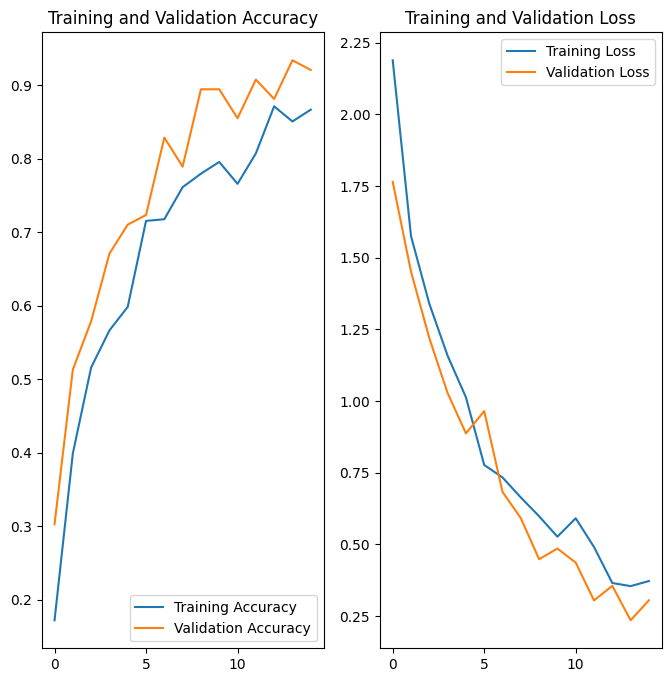

In [ ]:
plot_learning_curve(history, epochs)

107079/107079 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
81463/81463 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
72078/72078 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
64942/64942 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
92708/92708 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
98738/98738 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
53125/53125 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
70872/70872 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test accuracy on 8 random images: 100.00%


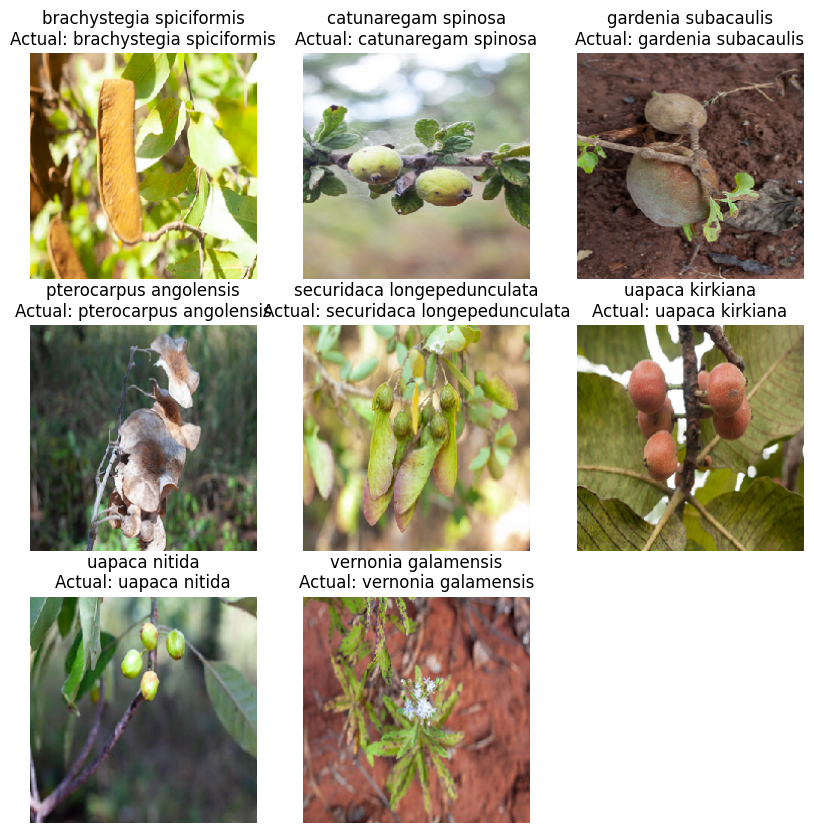

In [ ]:
test_images = [["brachystegia spiciformis", "https://os.skrypt.it/images/brachystegia_spiciformis/1.jpg"],
        ['catunaregam spinosa', "https://os.skrypt.it/images/catunaregam_spinosa/1.jpg"],
        ['gardenia subacaulis',"https://os.skrypt.it/images/gardenia_subacaulis/1.jpg"],
        ['pterocarpus angolensis', "https://os.skrypt.it/images/pterocarpus_angolensis/1.jpg"],
        ['securidaca longepedunculata', "https://os.skrypt.it/images/securidaca_longepedunculata/1.jpg"],
        ['uapaca kirkiana', "https://os.skrypt.it/images/uapaca_kirkiana/1.jpg"],
        ['uapaca nitida', "https://os.skrypt.it/images/uapaca_nitida/1.jpg"],
        ['vernonia galamensis', "https://os.skrypt.it/images/vernonia_galamensis/1.jpg"]
    ]
predict_images(best_model, test_images)

In [ ]:
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,341,818 (73.78 MB)

 Trainable params: 6,447,272 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,894,546 (49.19 MB)

In [ ]:
best_model.save("model.keras")

In [ ]:
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists("./models"):
    os.makedirs("./models")

model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
best_model.export(f"./models/{model_version}")

Saved artifact at './models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  134739898229232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739898226944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739900972576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739896877472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739896882752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739900968176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739896892256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739896891904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739897019632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739897024208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134739897023328: Tens

In [ ]:
import h5py
def export_model_to_h5(model, filepath='model.h5', try_all_methods=True):
    """
    Try multiple methods to export a model to H5 format

    Args:
        model: Keras model to save
        filepath: Path to save the H5 file
        try_all_methods: If True, tries all methods until one works
    """
    methods_tried = []

    # Method 1: Direct save with H5 format specified
    try:
        print("Trying Method 1: Direct save with H5 format...")
        model.save(filepath, save_format='h5')
        print(f"Success! Model saved to {filepath}")
        return True
    except Exception as e:
        methods_tried.append(f"Method 1 failed: {str(e)}")
        if not try_all_methods:
            raise e

    # Method 2: Save only weights
    try:
        print("Trying Method 2: Saving weights only...")
        weights_path = filepath.replace('.h5', '_weights.h5')
        model.save_weights(weights_path, save_format='h5')

        # Save model architecture as json
        json_path = filepath.replace('.h5', '_architecture.json')
        model_json = model.to_json()
        with open(json_path, 'w') as f:
            f.write(model_json)

        print(f"Success! Weights saved to {weights_path}")
        print(f"Architecture saved to {json_path}")
        return True
    except Exception as e:
        methods_tried.append(f"Method 2 failed: {str(e)}")
        if not try_all_methods:
            raise e

    # Method 3: Manual H5 export
    try:
        print("Trying Method 3: Manual H5 export...")
        # Get model weights as numpy arrays
        weight_values = model.get_weights()

        # Save weights manually using h5py
        with h5py.File(filepath, 'w') as f:
            weight_group = f.create_group('model_weights')
            for i, w in enumerate(weight_values):
                weight_group.create_dataset(f'weight_{i}', data=w)

            # Save model configuration
            if hasattr(model, 'get_config'):
                config = str(model.get_config())
                f.attrs['model_config'] = config

        print(f"Success! Model manually exported to {filepath}")
        return True
    except Exception as e:
        methods_tried.append(f"Method 3 failed: {str(e)}")
        if not try_all_methods:
            raise e

    # If all methods failed
    print("All export methods failed. Error details:")
    for error in methods_tried:
        print(error)
    return False

In [ ]:
export_model_to_h5(best_model, 'model.h5')

Trying Method 1: Direct save with H5 format...
Trying Method 2: Saving weights only...
Trying Method 3: Manual H5 export...
Success! Model manually exported to model.h5


True

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a custom object scope to serialize the preprocessing model
@tf.keras.utils.register_keras_serializable()
def preprocessing_model_fn():
  # Instead of using keras.Sequential directly, define the layers as a list
  # Return the list of layers which are serializable
  return [
      layers.RandomRotation(0.1),
      layers.RandomTranslation(0, 0.2),
      layers.RandomTranslation(0.2, 0),
      layers.RandomZoom(0.2, 0.2),
      layers.RandomFlip(mode="horizontal"),
  ]

# Rebuild the model using the custom object scope
model = Sequential([
  layers.InputLayer(input_shape=INPUT_SHAPE),
  *preprocessing_model_fn(), # Unpack the layers from the function
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

# Save the model using `save_model` and specify the 'h5' format
tf.keras.models.save_model(
    model,
    'model.hdf5',
    overwrite=True,
    include_optimizer=True,
    save_format='h5'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


TypeError: cannot pickle 'module' object

In [ ]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 'model'
export_path = version
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    best_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model



ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model.

In [ ]:
reconstructed_model = keras.models.load_model("model.keras")

In [ ]:
predict_images(reconstructed_model, test_images)

NameError: name 'reconstructed_model' is not defined

In [ ]:
import tempfile
import tensorflow as tf

# Define the model directory and version
MODEL_DIR = tempfile.gettempdir()
version = 1  # Use an integer for the version
export_path = os.path.join(MODEL_DIR, f"model_{version}.h5")
print('export_path = {}\n'.format(export_path))

# Save the model using the 'h5' format
tf.keras.models.save_model(
    best_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format='h5'  # Explicitly specify the save format
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/model_1.h5



TypeError: cannot pickle 'module' object

In [ ]:
# prompt: compress the models directory

import shutil
import os

# Define the directory to compress
models_dir = "./models"

# Define the output zip file name
output_filename = "models.zip"

# Create a zip archive of the models directory
shutil.make_archive(output_filename.split('.')[0], 'zip', models_dir)

print(f"Compressed '{models_dir}' to '{output_filename}'")

Compressed './models' to 'models.zip'


In [ ]:
!ls -lh

total 244M
-rw-r--r--  1 root root  74M Nov 14 05:03 1.keras
-rw-r--r--  1 root root  74M Nov 14 04:06 best_model.keras
drwxr-xr-x 10 root root 4.0K Nov 14 04:06 mizimu
-rw-r--r--  1 root root  31M Nov 14 04:06 mizimu.zip
-rw-r--r--  1 root root  11K Nov 14 04:43 model_architecture.json
-rw-r--r--  1 root root  800 Nov 14 04:12 model.h5
-rw-r--r--  1 root root  66M Nov 14 05:04 model.weights.zip
-rw-r--r--  1 root root  800 Nov 14 04:08 my_model.h5
drwxr-xr-x  1 root root 4.0K Nov 12 14:25 sample_data


In [ ]:
y_pred_probs = best_model.predict(val_ds)
y_pred = tf.argmax(y_pred_probs, axis=1)

y_true = tf.concat([y for x, y in val_ds], axis=0)

In [ ]:
loaded_model = tf.keras.models.load_model("./models/model.keras")

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

y_pred_probs = best_model.predict(val_ds)
y_pred = tf.argmax(y_pred_probs, axis=1)
y_true = tf.concat([y for x, y in val_ds], axis=0)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate and print ROC AUC score
if num_classes == 2:
    y_pred_probs_positive_class = y_pred_probs[:, 1]
    roc_auc = roc_auc_score(y_true, y_pred_probs_positive_class)
    print(f'ROC AUC Score: {roc_auc:.2f}')
else:
    y_true_one_hot = label_binarize(y_true, classes=range(num_classes))
    roc_auc_scores = []
    for i in range(num_classes):
        roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc_scores.append(roc_auc)
        print(f'{class_names[i]} ROC AUC Score: {roc_auc:.2f}')
    average_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)
    print(f'Average ROC AUC Score: {average_roc_auc:.2f}')

# Plot ROC curve for binary classification
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs_positive_class)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    # For multi-class, plot ROC curve for each class
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} ROC curve (area = {roc_auc_scores[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=.5, fmt='g', ax=ax)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

NameError: name 'y_true' is not defined

# Transfer Learning

In [ ]:
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
BATCH_SIZE = 16

In [ ]:
train_ds = build_dataset("training", label_mode="categorical", batch_size=1)
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

val_ds = build_dataset("validation", label_mode="categorical", batch_size=1)
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

Found 544 files belonging to 8 classes.
Using 436 files for training.
Found 544 files belonging to 8 classes.
Using 108 files for validation.


In [ ]:
do_fine_tuning = False
num_classes = len(class_names)

print("Building model with", model_handle)
tl_model = tf.keras.Sequential([
    normalization_layer,
    preprocessing_model,
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

tl_model.build((None,)+INPUT_SHAPE)
tl_model.summary()

NameError: name 'class_names' is not defined

In [ ]:
tl_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

NameError: name 'tl_model' is not defined

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
tl_history = tl_model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

NameError: name 'train_size' is not defined

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(tl_history["loss"])
plt.plot(tl_history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(tl_history["accuracy"])
plt.plot(tl_history["val_accuracy"])